# RS Oph
RS Oph is a binary system that undergoes recurrent **nova** eruption every ~15 years. The last one was in August 2021 and was extensively followed up at gamma rays. RS Oph is the first nova detected at gamma rays above 100 GeV.

In this notebook, we will model its gamma-ray emission.

<img src="images/RSOph.png" alt="RSOph" width="600">

Credit: David A.Hardy / www.astroart.org & PPARC.

In [1]:
# imports
from astropy.table import Table
import astropy.units as u
import naima
import numpy as np
import matplotlib.pyplot as plt
import subprocess
from IPython.display import Image
import matplotlib.animation as animation
import naima
from IPython.display import HTML
from astropy.visualization import quantity_support

# Display the SED

In [2]:
# Import necessary libraries
from astropy.table import Table  # For reading data tables
import matplotlib.pyplot as plt  # For plotting
import numpy as np  # For numerical operations
import matplotlib.animation as animation  # For animation
from IPython.display import HTML  # To display the animation

# Load the SED data for each day
sed_day1 = Table.read('../data/RSOph/RSOph_day1_diff_flux.ecsv', format='ascii.ecsv')
sed_day2 = Table.read('../data/RSOph/RSOph_day2_diff_flux.ecsv', format='ascii.ecsv')
sed_day3 = Table.read('../data/RSOph/RSOph_day3_diff_flux.ecsv', format='ascii.ecsv')
sed_day4 = Table.read('../data/RSOph/RSOph_day4_diff_flux.ecsv', format='ascii.ecsv')

# Group the data tables for easy access
daily_data = [sed_day1, sed_day2, sed_day3, sed_day4]

# Define the corresponding days
days = [1, 2, 3, 4]

# Create a plot figure and axis
fig, ax = plt.subplots(figsize=(6, 4))

# Update function for the animation
def update(frame):
    """
    Update the plot for each frame of the animation.
    """
    ax.clear()  # Clear the previous plot
    
    # Loop through each group and plot data for the current frame (day)
    for i in np.unique(daily_data[frame]['group'].value):
        mask_group = daily_data[frame]['group'].value == i
        mask_ul = daily_data[frame]['ul'].value == True

        # Plot normal data points
        ax.errorbar(
            x=daily_data[frame]["energy"].value[~mask_ul & mask_group],
            y=daily_data[frame]["energy"].value[~mask_ul & mask_group]**2 *\
                  daily_data[frame]["flux"].value[~mask_ul & mask_group],
            yerr=daily_data[frame]["energy"].value[~mask_ul & mask_group]**2 *\
                  daily_data[frame]["flux_error"].value[~mask_ul & mask_group],
            color=naima.plot.color_cycle[i],
            marker="o", ls=""
        )

        # Plot upper limit data points
        ax.errorbar(
            x=daily_data[frame]["energy"].value[mask_ul & mask_group],
            y=daily_data[frame]["energy"].value[mask_ul & mask_group]**2 *\
                  daily_data[frame]["flux"].value[mask_ul & mask_group],
            yerr=daily_data[frame]["energy"].value[mask_ul & mask_group]**2 *\
                  daily_data[frame]["flux"].value[mask_ul & mask_group] * 0.3,
            color=naima.plot.color_cycle[i],
            marker="o", ls="", uplims=True
        )

    # Set plot details (titles, axis limits, labels)
    ax.set_title(f"Day {days[frame]} after eruption")
    ax.set_xlim((0.00006, 2.6))
    ax.set_ylim((5e-14, 2e-08))
    ax.set_xlabel("Energy (TeV)")
    ax.set_ylabel(f"E$^2$ d$\phi$/dE (erg cm$^{{-2}}$ s$^{{-1}}$)")
    ax.set_xscale("log")
    ax.set_yscale("log")
    plt.tight_layout()
    plt.close()

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=len(daily_data), interval=1000, repeat=True)

# Save or display the animation
# ani.save("data_animation.gif", writer="pillow", fps=1)  # Uncomment to save as GIF

HTML(ani.to_jshtml())  # Display in Jupyter as JavaScript


The emission at gamma rays within the first four days after the eruption is variable!

- The emission decreases at GeV
- The emission increases at TeV

# Model fitting

Although a complex modelization would be required to model the temporal evolution of the particles and physical parameters of the system involved in the gamma-ray emission of RS Oph and account for the gamma-gamma absorption by the photons of the photosphere, below we will use a simple model with naima for this task.

Note that naima does not consider temporal evolution in the physical parameters. Therefore, we have to add it by hand. We will consider the parametrization in Acciari et al. 2022.

<img src="images/Schematic_model.png" alt="RSOph model" width="600">

Source: Acciari, V. A., Ansoldi, S., Antonelli, L. A., et al. 2022, Nature Astronomy, 6, 689

# Hadronic model 

Hadronic stands for a model that only accounts for processes involving hadrons in the interactions to explain the gamma-ray emission. In this case, we will use the neutral pion decay radiative process.

Note that secondary particles, e.g. electrons, can also produce gamma rays! We will not consider this possibility.

In [3]:
%%writefile RSOph_results/hadronic_model/RSOph_hadronic.py
# Magic command to write the content of the cell to a Python file

#imports
import astropy.units as u
import numpy as np 
import naima
from naima.models import ExponentialCutoffPowerLaw
from astropy.table import Table
import os

class PionDecayModel:
    """
    Define a model for the pion decay emission from a proton energy distribution
    following a power-law with exponential cut-off.
    
    The target proton density is parameterized as a function of the day
    after the nova explosion.
    """
    def __init__(self, day_value):
        # Initialize with the day after the nova explosion
        self.day_value = day_value

    def PionDecay(self, pars, data):
        """
        Define the particle distribution model, radiative model, and return model flux
        at the given energy values from data.

        Parameters:
        pars : array
            Parameters for the model (e.g., normalization, index, cutoff).
        data : Table
            The energy data for which flux needs to be calculated.
        
        Returns:
        flux : Quantity
            The calculated flux at the given energy values.
        """
        # Define particle distribution model with exponential cutoff
        ECPL = ExponentialCutoffPowerLaw(
            10 ** pars[0] / u.eV, 130 * u.GeV, pars[1], 10 ** pars[2] * u.GeV
        )

        # Define the pion decay model using the particle distribution and target density
        PP = naima.models.PionDecay(ECPL, nh=6.0e8 * (self.day_value / 3) ** (-3) * u.cm ** -3)

        # Return the flux for the given energy values
        return PP.flux(data, distance=2.45 * u.kpc)

def lnprior(pars):
    """
    Define a prior distribution for the model parameters.
    Limits the amplitude (norm) to positive values.

    Parameters:
    pars : array
        Parameters for the model.

    Returns:
    logprob : float
        The log probability of the parameters.
    """
    # Limit amplitude to positive domain (uniform prior)
    logprob = naima.uniform_prior(pars[0], 0, np.inf)
               
    return logprob


if __name__ == '__main__':
    # Read in the SED data for each day from CSV files
    sed_day1 = Table.read('../data/RSOph/RSOph_day1_diff_flux.ecsv', format='ascii.ecsv')
    sed_day2 = Table.read('../data/RSOph/RSOph_day2_diff_flux.ecsv', format='ascii.ecsv')
    sed_day3 = Table.read('../data/RSOph/RSOph_day3_diff_flux.ecsv', format='ascii.ecsv')
    sed_day4 = Table.read('../data/RSOph/RSOph_day4_diff_flux.ecsv', format='ascii.ecsv')

    # Group the SED data by day
    daily_data = [sed_day1, sed_day2, sed_day3, sed_day4]

    # Set initial parameters and labels for the model
    p0 = np.array((31, 2.5, np.log10(200)))  # Initial guesses for model parameters
    labels = ["log10(norm)", "index", "log10(cutoff)"]  # Labels for the parameters
    day_array = [1, 2, 3, 4]  # Days after the nova explosion

    # Clean up previous results if they exist
    os.system("rm RSOph_results/hadronic_model/fit_naima_results_all*")

    # Loop over the data for each day
    for yy, iday in enumerate(day_array):
        p0 = np.array((31, 2.5, np.log10(200)))  # Reset initial parameters for each day
        day_value = iday  # Set the day value

        print("day", day_value)

        # Create the model function with the appropriate day value
        PionDecay_func = PionDecayModel(iday)
        
        # Run the sampler to fit the model to the data
        sampler, pos = naima.run_sampler(
            data_table=daily_data[yy],  # Use the data for the current day
            p0=p0,  # Initial parameter guesses
            labels=labels,  # Parameter labels
            model=PionDecay_func.PionDecay,  # Model to fit
            prior=lnprior,  # Prior distribution for parameters
            nwalkers=32,  # Number of walkers for the MCMC sampler
            nburn=10,  # Number of burn-in steps
            nrun=40,  # Number of steps to run the sampler
            threads=4,  # Number of threads to use
            prefit=True,  # Whether to perform a prefit
            interactive=False,  # Whether to allow interactive plotting
        )

        # Save the results of the fitting process
        out_root = "RSOph_results/hadronic_model/fit_naima_results_all_day{}".format(day_array[yy])
        naima.save_run(out_root + ".hdf5", sampler)  # Save the sampler output in HDF5 format

        # Save diagnostic plots and the results table
        naima.save_diagnostic_plots(out_root, sampler, sed=True)
        naima.save_results_table(out_root, sampler) 

        print( )
        print( )


Overwriting RSOph_results/hadronic_model/RSOph_hadronic.py


Execute the script.

In [4]:
subprocess.run(["python","RSOph_results/hadronic_model/RSOph_hadronic.py"])

day 1
INFO: Finding Maximum Likelihood parameters through Nelder-Mead fitting... [naima.core]
INFO:    Initial parameters: [31.00620822  2.5         2.30103   ] [naima.core]
INFO:    Initial lnprob(p0): -456.032 [naima.core]
INFO:    New ML parameters : [30.5511529   2.48024554  2.43099639] [naima.core]
INFO:    Maximum lnprob(p0): -8.249 [naima.core]


/Users/aaguasca/anaconda3/envs/naima_handson/lib/python3.11/site-packages/naima/analysis.py:153: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  f.clf()


Burning in the 32 walkers with 10 steps...

Progress of the run: 0 percent (0 of 10 steps)
                           --log10(norm)-- -----index----- -log10(cutoff)-
  Last ensemble median :      30.5            2.48            2.43      
  Last ensemble std    :      0.161          0.0162          0.0124     
  Last ensemble lnprob :  avg: -44.191, max: -8.672

Progress of the run: 10 percent (1 of 10 steps)
                           --log10(norm)-- -----index----- -log10(cutoff)-
  Last ensemble median :      30.5            2.48            2.43      
  Last ensemble std    :      0.152          0.0175          0.0136     
  Last ensemble lnprob :  avg: -39.789, max: -8.622

Progress of the run: 20 percent (2 of 10 steps)
                           --log10(norm)-- -----index----- -log10(cutoff)-
  Last ensemble median :      30.5            2.48            2.43      
  Last ensemble std    :      0.143          0.0175          0.0134     
  Last ensemble lnprob :  avg: -33.429, max:

/Users/aaguasca/anaconda3/envs/naima_handson/lib/python3.11/site-packages/naima/analysis.py:153: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  f.clf()


Burning in the 32 walkers with 10 steps...

Progress of the run: 0 percent (0 of 10 steps)
                           --log10(norm)-- -----index----- -log10(cutoff)-
  Last ensemble median :      31.1            2.68            2.93      
  Last ensemble std    :      0.164           0.016          0.0235     
  Last ensemble lnprob :  avg: -30.767, max: -11.376

Progress of the run: 10 percent (1 of 10 steps)
                           --log10(norm)-- -----index----- -log10(cutoff)-
  Last ensemble median :      31.1            2.68            2.93      
  Last ensemble std    :      0.152          0.0163          0.0245     
  Last ensemble lnprob :  avg: -25.418, max: -11.374

Progress of the run: 20 percent (2 of 10 steps)
                           --log10(norm)-- -----index----- -log10(cutoff)-
  Last ensemble median :      31.1            2.68            2.93      
  Last ensemble std    :      0.137          0.0189          0.0246     
  Last ensemble lnprob :  avg: -23.849, ma

/Users/aaguasca/anaconda3/envs/naima_handson/lib/python3.11/site-packages/naima/analysis.py:153: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  f.clf()


Burning in the 32 walkers with 10 steps...

Progress of the run: 0 percent (0 of 10 steps)
                           --log10(norm)-- -----index----- -log10(cutoff)-
  Last ensemble median :      31.4            2.74            3.41      
  Last ensemble std    :      0.147          0.0131          0.0224     
  Last ensemble lnprob :  avg: -28.597, max: -11.733

Progress of the run: 10 percent (1 of 10 steps)
                           --log10(norm)-- -----index----- -log10(cutoff)-
  Last ensemble median :      31.4            2.74            3.41      
  Last ensemble std    :      0.138          0.0136          0.0272     
  Last ensemble lnprob :  avg: -27.059, max: -11.733

Progress of the run: 20 percent (2 of 10 steps)
                           --log10(norm)-- -----index----- -log10(cutoff)-
  Last ensemble median :      31.4            2.74            3.41      
  Last ensemble std    :      0.134          0.0151          0.0272     
  Last ensemble lnprob :  avg: -25.893, ma

/Users/aaguasca/anaconda3/envs/naima_handson/lib/python3.11/site-packages/naima/analysis.py:153: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  f.clf()
Exception ignored in: <function Pool.__del__ at 0x12975eac0>
Traceback (most recent call last):
  File "/Users/aaguasca/anaconda3/envs/naima_handson/lib/python3.11/multiprocessing/pool.py", line 271, in __del__
  File "/Users/aaguasca/anaconda3/envs/naima_handson/lib/python3.11/multiprocessing/queues.py", line 371, in put
AttributeError: 'NoneType' object has no attribute 'dumps'


Burning in the 32 walkers with 10 steps...

Progress of the run: 0 percent (0 of 10 steps)
                           --log10(norm)-- -----index----- -log10(cutoff)-
  Last ensemble median :      31.7            2.67            3.31      
  Last ensemble std    :      0.161          0.0138          0.0198     
  Last ensemble lnprob :  avg: -26.893, max: -13.257

Progress of the run: 10 percent (1 of 10 steps)
                           --log10(norm)-- -----index----- -log10(cutoff)-
  Last ensemble median :      31.7            2.67            3.31      
  Last ensemble std    :      0.152          0.0134          0.0198     
  Last ensemble lnprob :  avg: -25.860, max: -13.253

Progress of the run: 20 percent (2 of 10 steps)
                           --log10(norm)-- -----index----- -log10(cutoff)-
  Last ensemble median :      31.7            2.67            3.31      
  Last ensemble std    :      0.142          0.0153          0.0213     
  Last ensemble lnprob :  avg: -22.652, ma

CompletedProcess(args=['python', 'RSOph_results/hadronic_model/RSOph_hadronic.py'], returncode=0)

## Check the results

The script has finished. Let's check the results...

In [5]:
# Load results
tabs_hadronic = []
for day in days:
    tab = Table.read(f"RSOph_results/hadronic_model/fit_naima_results_all_day{day}_results.ecsv")
    tabs_hadronic.append(tab) 

Display the table with the best-fit parameter values

In [6]:
display(tabs_hadronic[0])

label,median,unc_lo,unc_hi
str13,float64,float64,float64
log10(norm),30.52787992415482,0.0755768185026291,0.07148755957039654
norm,3.3719409667144024e+30,5.3857206193722785e+29,6.0333685637773095e+29
index,2.4886489692465767,0.04876635500133286,0.06581731918117883
log10(cutoff),2.4346721894942767,0.05484735593301915,0.07123966142424676
cutoff,272.0646957012861,32.278044767554405,48.49721360481493
blob1,nan,nan,nan


In [7]:
# You can also load the hdf5 files
runs_hardonic = []
for day in days:
    file = f"RSOph_results/hadronic_model/fit_naima_results_all_day{day}.hdf5"
    run = naima.read_run(file, modelfn=None)
    runs_hardonic.append(run)
# naima.plot_corner(runs_hardonic[0]);
# naima.plot_chain(runs_hardonic[0], 0);

### Diagnostic plots

#### Check the posterior distribution of a given parameter

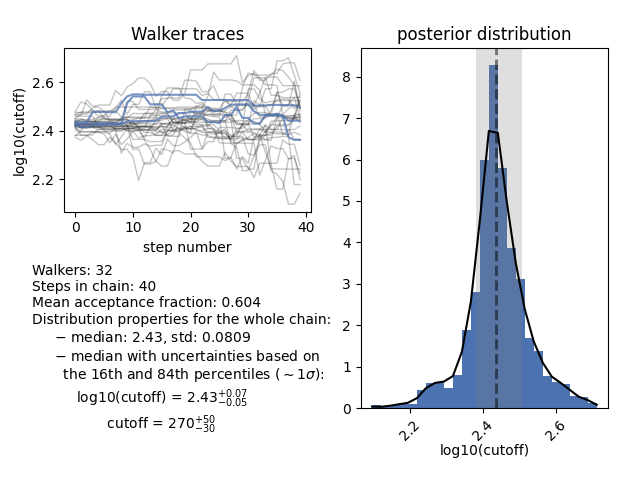

In [8]:
Image("RSOph_results/hadronic_model/fit_naima_results_all_day1_chain_cutoff.png")


It shows the parameter value with respect to the step number of the chain, which can be used to assess the stability of the chain (blue traces highlight 5% of the walkers), a plot of the posterior distribution, and several statistics of the posterior distribution. One of these is the median and 16th and 84th percentiles of the distribution, which can be reported as the inferred marginalised value of the parameter and associated 1sigma uncertainty.

#### Check the corner plot

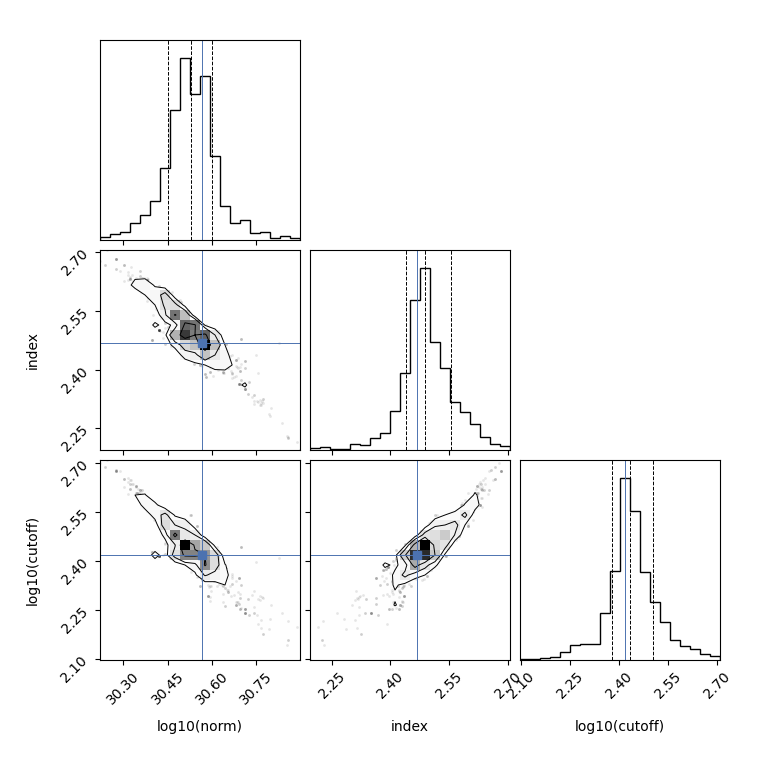

In [9]:
Image("RSOph_results/hadronic_model/fit_naima_results_all_day1_corner.png")


The relationship between the samples of the different parameters can be seen through a corner plot. The maximum likelihood parameter vector can be indicated with a cross.

- Do the dependencies between the different parameters make sense? Are they correlated?

#### Check the model output

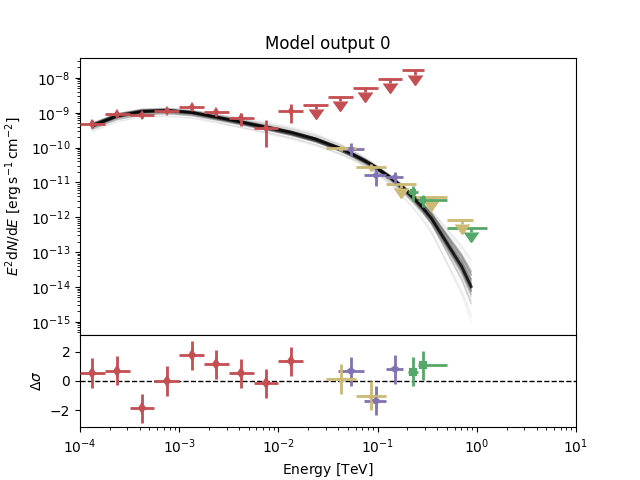

In [10]:
Image("RSOph_results/hadronic_model/fit_naima_results_all_day1_model0.png")

Here we see the representation of the results of the MCMC fitting on the SED. It shows the Maximum Likelihood model with a black line and 100 samples from the posterior distribution in grey.

However, these are diagnostic plots. They are not usually used in papers they are for diagnostics.

Now we want to produce the latest plot: display the best-fit model with the SED data.

Firstly, we have to use the best-fit particle energy distribution. Secondly, create the radiative model.

In [11]:
#Day 1
# Create the particle energy distribution using the best-fit values
particle_distribution_day1 = naima.models.ExponentialCutoffPowerLaw(
    tabs_hadronic[0]["median"][1]*u.Unit('1/eV'), 
    130.0 * u.GeV, 
    tabs_hadronic[0]["median"][2], 
    tabs_hadronic[0]["median"][4]*u.GeV
)
# Create the radiative model
radiative_model_day1 = naima.models.PionDecay(
    particle_distribution_day1, nh=6.0e8*(1/3)**(-3) * u.cm ** -3
)

#Day 2
particle_distribution_day2 = naima.models.ExponentialCutoffPowerLaw(
    tabs_hadronic[1]["median"][1]*u.Unit('1/eV'), 
    130.0 * u.GeV, 
    tabs_hadronic[1]["median"][2], 
    tabs_hadronic[1]["median"][4]*u.GeV
)
radiative_model_day2 = naima.models.PionDecay(
    particle_distribution_day2, nh=6.0e8*(2/3)**(-3) * u.cm ** -3
)

#Day 3
particle_distribution_day3 = naima.models.ExponentialCutoffPowerLaw(
    tabs_hadronic[2]["median"][1]*u.Unit('1/eV'), 
    130.0 * u.GeV, 
    tabs_hadronic[2]["median"][2], 
    tabs_hadronic[2]["median"][4]*u.GeV
)
radiative_model_day3 = naima.models.PionDecay(
    particle_distribution_day3, nh=6.0e8*(3/3)**(-3) * u.cm ** -3
)

#Day 4
particle_distribution_day4 = naima.models.ExponentialCutoffPowerLaw(
    tabs_hadronic[3]["median"][1]*u.Unit('1/eV'), 
    130.0 * u.GeV, 
    tabs_hadronic[3]["median"][2], 
    tabs_hadronic[3]["median"][4]*u.GeV
)
radiative_model_day4 = naima.models.PionDecay(
    particle_distribution_day4, nh=6.0e8*(4/3)**(-3) * u.cm ** -3
)

We are ready to show the results

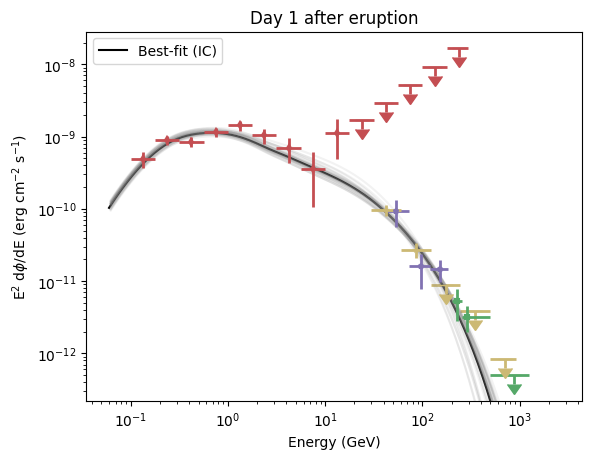

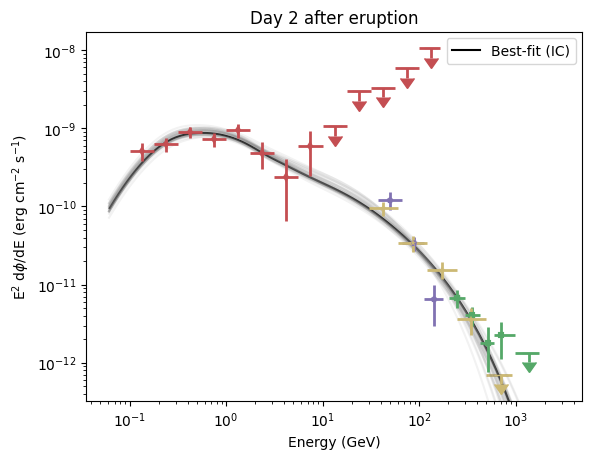

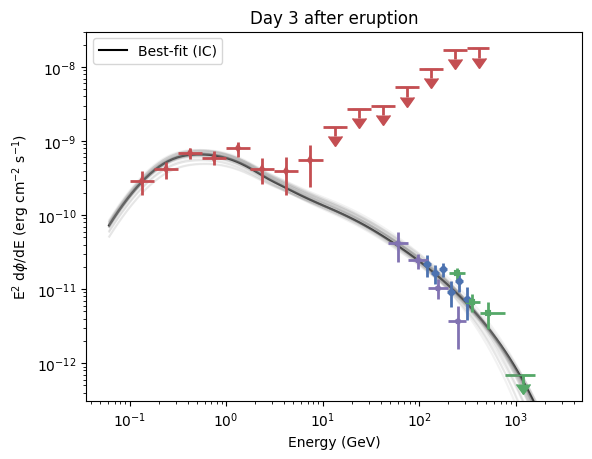

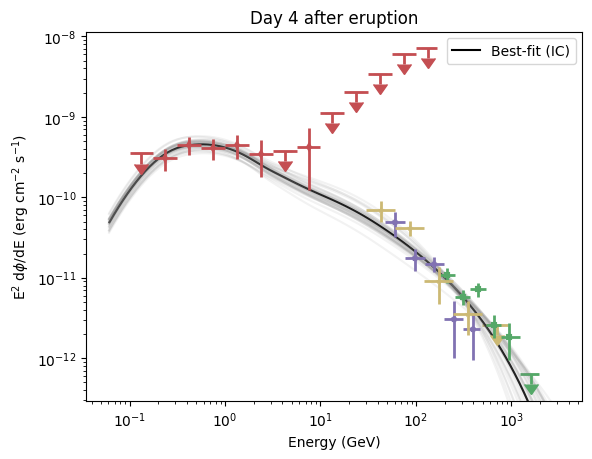

In [12]:
# import the class PionDecayModel from the file we created before
from RSOph_results.hadronic_model.RSOph_hadronic import PionDecayModel

# Define photon energy range for plotting SED (Spectral Energy Distribution)
photon_energy = np.geomspace(6e-5, 2.6, 100) * u.TeV

# Use the quantity_support context manager to enable operations with quantities
with quantity_support():
    # Loop through days, corresponding data, and radiative models
    for ii, (day, data, rad_model) in enumerate(
        zip(
            days,
            daily_data,
            [radiative_model_day1, radiative_model_day2, radiative_model_day3, radiative_model_day4]
        )
    ):
        # Create a plot of the data for each day using the 'naima' plotting function
        fig = naima.plot_data(data, e_unit=u.GeV)  # Plot data with energy unit as GeV
        ax = fig.axes[0]  # Get the plot axis
        ax.set_title(f"Day {day} after eruption")  # Set plot title with the day of observation

        # Set units for the x-axis and y-axis
        ax.xaxis.units = u.GeV  # Set the x-axis to be in GeV
        ax.yaxis.units = u.Unit("erg s-1 cm-2")  # Set the y-axis to have units of erg/s/cm^2

        # Store the current axis limits for both x and y
        ymin, ymax = ax.get_ylim()
        xmin, xmax = ax.get_xlim()

        # Plot the best-fit Inverse Compton (IC) SED
        plt.loglog(
            photon_energy,  # The photon energies to plot
            rad_model.sed(photon_energy, distance=2.45 * u.kpc),  # Calculate and plot the model flux (SED)
            color="k",  # Color of the line
            label=r"Best-fit (IC)"  # Label for the plot
        )

        # Create a PionDecay model for the current day
        PionDecay_func = PionDecayModel(day)

        # Loop through each MCMC chain sample and plot the corresponding flux
        for i in range(min(np.shape(runs_hardonic[ii].get_chain())[1], 100)):
            photon_energy = np.geomspace(xmin, xmax, 100) * u.GeV  # Define photon energy range for plotting
            # Get flux prediction from the PionDecay model for this sample in the MCMC chain
            flux = PionDecay_func.PionDecay(runs_hardonic[ii].get_chain()[-1, i, :], data=photon_energy)
            # SED := E**2 * differential flux (d\phi/dE), plot each flux sample in gray with some transparency
            plt.loglog(photon_energy, photon_energy**2 * flux, color="gray", alpha=0.1)

        # Restore the original y-axis limits to avoid distorting the plot
        ax.set_ylim((ymin, ymax))
        # Set axis labels for the plot
        ax.set_ylabel(f"E$^2$ d$\phi$/dE (erg cm$^{{-2}}$ s$^{{-1}}$)")  # y-axis label (flux)
        ax.set_xlabel(f"Energy (GeV)")  # x-axis label (energy)

        # Add a legend to the plot
        ax.legend()

#### Plot the maximum likelihood model parameter results

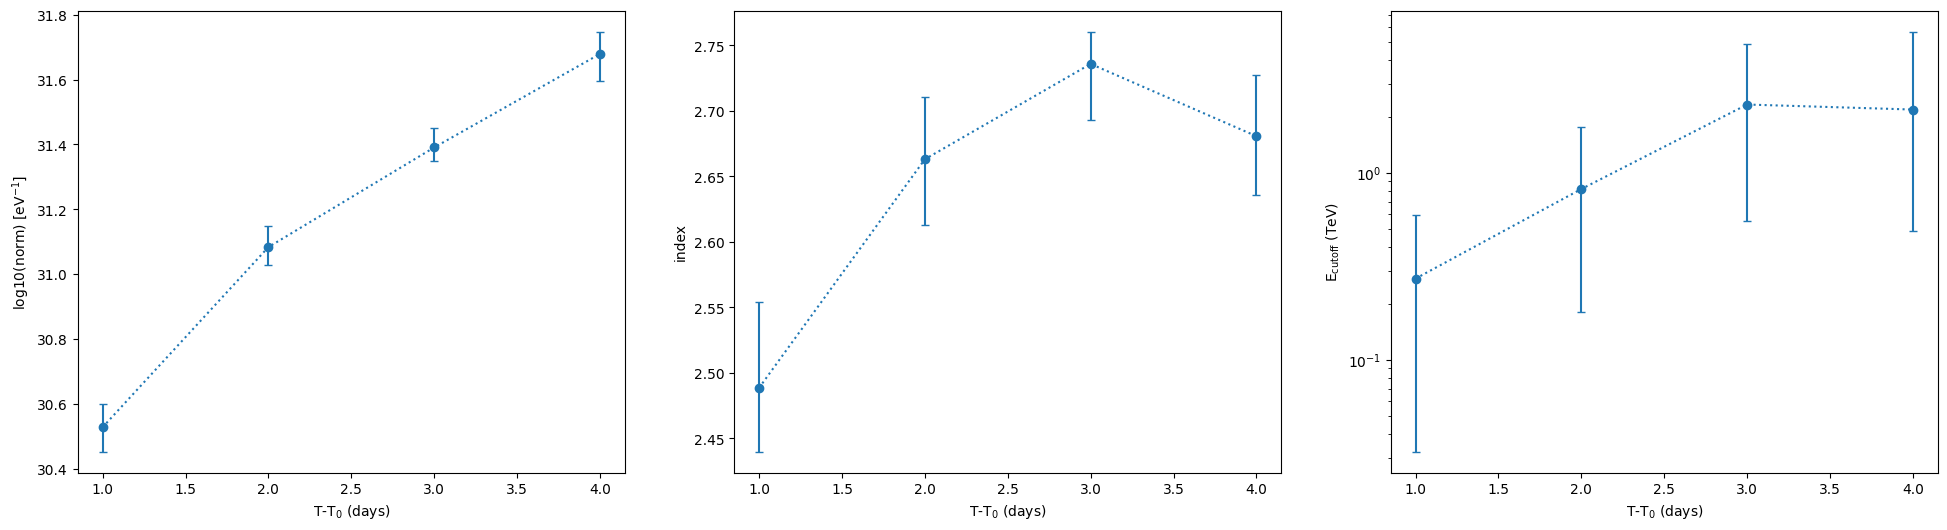

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize lists to store parameter values and uncertainties
tabs_val = []
tabs_err_lo = []
tabs_err_hi = []
labels = ["log10(norm)", "index", "cutoff"]

# Extract values and uncertainties for selected parameters
for tab in tabs_hadronic:
    tab_val, tab_err_lo, tab_err_hi = [], [], []    
    for i in range(len(tab)):
        if tab["label"][i] in labels:
            tab_val.append(tab["median"][i])
            tab_err_lo.append(tab["unc_lo"][i])
            tab_err_hi.append(tab["unc_hi"][i])
    tabs_val.append(tab_val)
    tabs_err_lo.append(tab_err_lo)
    tabs_err_hi.append(tab_err_hi)

# Convert lists to numpy arrays
tabs_val = np.array(tabs_val)
tabs_err_lo = np.array(tabs_err_lo)
tabs_err_hi = np.array(tabs_err_hi)

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(24, 6))

# Plot the log of the amplitude (norm)
axs[0].errorbar(
    x=days, y=tabs_val[:, 0], 
    yerr=[tabs_err_lo[:, 0], tabs_err_hi[:, 0]],
    ls=":", capsize=3, marker="o"
)
axs[0].set_ylabel(fr"{labels[0]} [eV$^{{-1}}$]")
axs[0].set_xlabel(r"T-T$_0$ (days)")

# Plot the power-law index
axs[1].errorbar(
    x=days, y=tabs_val[:, 1], 
    yerr=[tabs_err_lo[:, 1], tabs_err_hi[:, 1]], 
    ls=":", capsize=3, marker="o"
)
axs[1].set_ylabel(labels[1])
axs[1].set_xlabel(r"T-T$_0$ (days)")

# Plot the cutoff energy
axs[2].errorbar(
    x=days, y=tabs_val[:, 2] / 1000, # GeV -> TeV
    yerr=[(tabs_val[:, 2] - tabs_err_lo[:, 2]) / 1000, 
          (tabs_val[:, 2] + tabs_err_hi[:, 2]) / 1000], 
        ls=":", capsize=3, marker="o"
)
axs[2].set_yscale("log")
axs[2].set_ylabel(fr"E$_{{\rm cutoff}}$ (TeV)")
axs[2].set_xlabel(r"T-T$_0$ (days)");

#### Plot the proton energy distribution

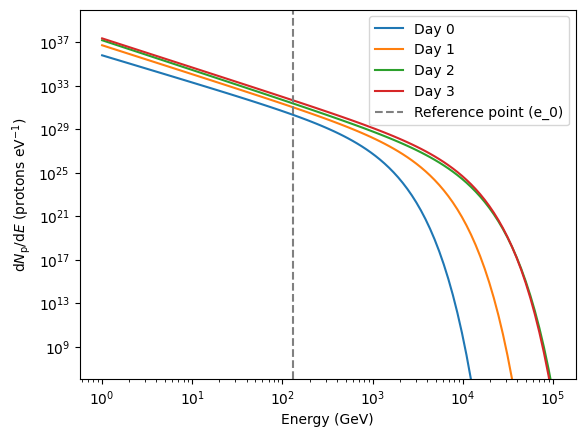

In [14]:
# range of proton energies
Penergy=np.geomspace(1,1e5,100)*u.GeV

# plot the electron energy distribution for each day
for ii,particle_distribution in enumerate([
    particle_distribution_day1, 
    particle_distribution_day2, 
    particle_distribution_day3, 
    particle_distribution_day4
]):
    plt.loglog(
        Penergy,
        particle_distribution._calc(Penergy), # evaluate the model at that energy
        label=f"Day {ii}",
    )

# mark the reference energy of the model (i.e. the energy of the amplitude value)
plt.vlines(130,1e6,1e40,ls="--",color="gray",label="Reference point (e_0)")

plt.legend()
plt.ylim((1e6,1e40))
plt.xlabel("Energy (GeV)")
plt.ylabel(f"d$N_{{\\rm p}}$/d$E$ (protons eV$^{{-1}}$)");

# Leptonic model

In this case, we use electrons to explain the gamma-ray emission. We will use the inverse Compton scattering.

In [15]:
%%writefile RSOph_results/leptonic_model/RSOph_leptonic.py

# Import necessary libraries
import astropy.units as u
import numpy as np
from astropy.io import ascii
from astropy.table import vstack
import naima
from naima.models import ExponentialCutoffPowerLaw, InverseCompton
import os
from astropy.table import Table

class ICmodel:
    """
    Define a model for the Inverse Compton (IC) emission from an electron distribution,
    following a power-law with exponential cut-off.
    
    The photon energy density is parameterized as a function of the day
    after the nova explosion. The characteristic photon temperature is
    also day-dependent.
    """
    def __init__(self, day_value):
        assert day_value in [1, 2, 3, 4]  # Ensure that the day_value is valid (1 to 4)
        self.day_value = day_value
        # Array of photon temperatures for each day after nova explosion
        Temp_value_array = [10780, 9500, 8460, 7680]
        # Select the temperature for the current day
        self.Temp_value = Temp_value_array[self.day_value - 1]

    def IC(self, pars, data):
        """
        Define particle distribution model, radiative model, and return 
        the flux at the provided energy values.

        Parameters
        ----------
        pars : list
            The model parameters: [amplitude, index, log10(cutoff)].
        data : Table
            Data table containing energy and flux values.

        Returns
        -------
        flux : Quantity
            The computed flux at the provided energy values.
        """
        # Extract parameters for the model: amplitude, index, and cutoff energy
        amplitude = 10**pars[0] / u.eV  # Convert amplitude to proper units (eV^-1)
        alpha = pars[1]  # Spectral index
        e_cutoff = (10 ** pars[2]) * u.GeV  # Exponential cutoff energy

        # Define the Exponential Cutoff Power Law particle distribution model
        ECPL = ExponentialCutoffPowerLaw(amplitude, 130 * u.GeV, alpha, e_cutoff)
        
        # Define the Inverse Compton radiative model using CMB and photosphere photon fields
        IC = InverseCompton(
            ECPL,
            seed_photon_fields=[
                "CMB",  # Cosmic Microwave Background
                ["photosphere", 
                 self.Temp_value * u.K,  # Temperature of the photosphere (dependent on day)
                 0.14 * ((self.Temp_value / 8460) ** 4 / (self.day_value / 3) ** 2) * u.Unit("erg cm-3")]
            ],
        )
        # Compute the flux based on the provided data and distance
        return IC.flux(data, distance=2.45 * u.kpc)


def lnprior(pars):
    """
    Define the prior distribution for the model parameters.
    The amplitude is constrained to be positive.

    Parameters
    ----------
    pars : list
        Model parameters.

    Returns
    -------
    logprob : float
        The logarithmic prior probability for the parameters.
    """
    # Limit amplitude to positive values using a uniform prior
    logprob = naima.uniform_prior(pars[0], 0, np.inf)
    return logprob

if __name__ == '__main__':

    # Set initial model parameters and labels for MCMC sampling
    labels = ["log10(norm)", "index", "log10(cutoff)"]
    day_array = [1, 2, 3, 4]  # Days for which data will be used

    # Read the SED data for each day
    sed_day1 = Table.read('../data/RSOph/RSOph_day1_diff_flux.ecsv', format='ascii.ecsv')
    sed_day2 = Table.read('../data/RSOph/RSOph_day2_diff_flux.ecsv', format='ascii.ecsv')
    sed_day3 = Table.read('../data/RSOph/RSOph_day3_diff_flux.ecsv', format='ascii.ecsv')
    sed_day4 = Table.read('../data/RSOph/RSOph_day4_diff_flux.ecsv', format='ascii.ecsv')

    # Group the daily data into a list for easy access
    daily_data = [sed_day1, sed_day2, sed_day3, sed_day4]

    # Remove any previous results to avoid overwriting issues
    os.system("rm RSOph_results/leptonic_model/fit_naima_results_all*")

    # Loop through each day of data
    for yy, iday in enumerate(day_array):
        
        p0 = np.array((27, 2.5, np.log10(200)))  # Initial guess for model parameters
        day_value = iday  # Set the current day value
        IC_func = ICmodel(day_value)  # Create the IC model for the current day

        print("day", day_value)

        # Run the MCMC sampler to fit the model to the data
        sampler, pos = naima.run_sampler(
            data_table=daily_data[yy],  # The data for the current day
            p0=p0,  # Initial parameters
            labels=labels,  # Parameter labels
            model=IC_func.IC,  # The model to fit (IC emission)
            prior=lnprior,  # The prior distribution
            nwalkers=50,  # Number of walkers in the MCMC chain
            nburn=50,  # Number of burn-in steps
            nrun=40,  # Number of sampling steps
            prefit=True,  # Perform a prefitting step with the initial parameters
            interactive=True,  # Allow interactive adjustment of p0 (only in command line)
        )
        
        # Save the results of the sampling run to a file
        out_root = "RSOph_results/leptonic_model/fit_naima_results_all_day{}".format(day_array[yy])
        naima.save_run(out_root + ".hdf5", sampler)

        # Save diagnostic plots and results table
        naima.save_diagnostic_plots(out_root, sampler, sed=True)
        naima.save_results_table(out_root, sampler)

        print()
        print()

Overwriting RSOph_results/leptonic_model/RSOph_leptonic.py


In [16]:
subprocess.run(["python","RSOph_results/leptonic_model/RSOph_leptonic.py"])

rm: RSOph_results/leptonic_model/fit_naima_results_all*: No such file or directory


day 1
INFO: Launching interactive model fitter, close when finished [naima.core]
Figure(640x480)
INFO: Finding Maximum Likelihood parameters through Nelder-Mead fitting... [naima.core]
INFO:    Initial parameters: [28.35270949  2.5         2.30103   ] [naima.core]
INFO:    Initial lnprob(p0): -13766.914 [naima.core]
INFO:    New ML parameters : [27.40187204  2.9310723   2.0501191 ] [naima.core]
INFO:    Maximum lnprob(p0): -21.255 [naima.core]


/Users/aaguasca/anaconda3/envs/naima_handson/lib/python3.11/site-packages/naima/analysis.py:153: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  f.clf()


Burning in the 50 walkers with 50 steps...

Progress of the run: 0 percent (0 of 50 steps)
                           --log10(norm)-- -----index----- -log10(cutoff)-
  Last ensemble median :      27.4            2.93            2.05      
  Last ensemble std    :      0.145          0.0173          0.00981    
  Last ensemble lnprob :  avg: -36.196, max: -21.199

Progress of the run: 10 percent (5 of 50 steps)
                           --log10(norm)-- -----index----- -log10(cutoff)-
  Last ensemble median :      27.4            2.93            2.05      
  Last ensemble std    :     0.0819          0.0168          0.0111     
  Last ensemble lnprob :  avg: -26.094, max: -21.160

Progress of the run: 20 percent (10 of 50 steps)
                           --log10(norm)-- -----index----- -log10(cutoff)-
  Last ensemble median :      27.4            2.93            2.05      
  Last ensemble std    :     0.0567          0.0201           0.015     
  Last ensemble lnprob :  avg: -23.683, m

/Users/aaguasca/anaconda3/envs/naima_handson/lib/python3.11/site-packages/naima/analysis.py:153: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  f.clf()


Burning in the 50 walkers with 50 steps...

Progress of the run: 0 percent (0 of 50 steps)
                           --log10(norm)-- -----index----- -log10(cutoff)-
  Last ensemble median :      27.8            3.14            2.54      
  Last ensemble std    :      0.113          0.0143          0.0123     
  Last ensemble lnprob :  avg: -25.506, max: -17.236

Progress of the run: 10 percent (5 of 50 steps)
                           --log10(norm)-- -----index----- -log10(cutoff)-
  Last ensemble median :      27.8            3.15            2.54      
  Last ensemble std    :     0.0785          0.0227          0.0167     
  Last ensemble lnprob :  avg: -20.650, max: -17.209

Progress of the run: 20 percent (10 of 50 steps)
                           --log10(norm)-- -----index----- -log10(cutoff)-
  Last ensemble median :      27.8            3.14            2.54      
  Last ensemble std    :      0.056          0.0248           0.022     
  Last ensemble lnprob :  avg: -19.069, m

/Users/aaguasca/anaconda3/envs/naima_handson/lib/python3.11/site-packages/naima/analysis.py:153: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  f.clf()


Burning in the 50 walkers with 50 steps...

Progress of the run: 0 percent (0 of 50 steps)
                           --log10(norm)-- -----index----- -log10(cutoff)-
  Last ensemble median :      28.2            3.18            3.03      
  Last ensemble std    :      0.151          0.0164          0.0147     
  Last ensemble lnprob :  avg: -45.750, max: -21.073

Progress of the run: 10 percent (5 of 50 steps)
                           --log10(norm)-- -----index----- -log10(cutoff)-
  Last ensemble median :      28.2            3.17            3.04      
  Last ensemble std    :     0.0932          0.0197           0.018     
  Last ensemble lnprob :  avg: -29.878, max: -21.037

Progress of the run: 20 percent (10 of 50 steps)
                           --log10(norm)-- -----index----- -log10(cutoff)-
  Last ensemble median :      28.1            3.17            3.03      
  Last ensemble std    :     0.0656          0.0243          0.0263     
  Last ensemble lnprob :  avg: -24.236, m

/Users/aaguasca/anaconda3/envs/naima_handson/lib/python3.11/site-packages/naima/analysis.py:153: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  f.clf()
Exception ignored in: <function Pool.__del__ at 0x159c722a0>
Traceback (most recent call last):
  File "/Users/aaguasca/anaconda3/envs/naima_handson/lib/python3.11/multiprocessing/pool.py", line 271, in __del__
  File "/Users/aaguasca/anaconda3/envs/naima_handson/lib/python3.11/multiprocessing/queues.py", line 371, in put
AttributeError: 'NoneType' object has no attribute 'dumps'


Burning in the 50 walkers with 50 steps...

Progress of the run: 0 percent (0 of 50 steps)
                           --log10(norm)-- -----index----- -log10(cutoff)-
  Last ensemble median :      28.4            3.15            3.16      
  Last ensemble std    :      0.113          0.0172          0.0217     
  Last ensemble lnprob :  avg: -24.519, max: -16.305

Progress of the run: 10 percent (5 of 50 steps)
                           --log10(norm)-- -----index----- -log10(cutoff)-
  Last ensemble median :      28.4            3.16            3.16      
  Last ensemble std    :     0.0756          0.0246          0.0339     
  Last ensemble lnprob :  avg: -20.524, max: -16.061

Progress of the run: 20 percent (10 of 50 steps)
                           --log10(norm)-- -----index----- -log10(cutoff)-
  Last ensemble median :      28.4            3.15            3.15      
  Last ensemble std    :     0.0547          0.0389          0.0586     
  Last ensemble lnprob :  avg: -18.656, m

CompletedProcess(args=['python', 'RSOph_results/leptonic_model/RSOph_leptonic.py'], returncode=0)

We do the same steps as in the hadronic case to access the results and show the gamma-ray emission of the best-fit models

In [17]:
# Load results
tabs_leptonic=[]
for day in [1,2,3,4]:
    tab=Table.read(f"RSOph_results/leptonic_model/fit_naima_results_all_day{day}_results.ecsv")
    tabs_leptonic.append(tab) 

In [18]:
display(tabs_leptonic[0])

label,median,unc_lo,unc_hi
str13,float64,float64,float64
log10(norm),27.88280837083944,0.28830750812501194,0.3405239806028071
norm,7.63498821307367e+27,3.704006865950426e+27,9.088711137496972e+27
index,2.6377770252101262,0.21406106731224428,0.1897236614683675
log10(cutoff),1.7139702554242295,0.15002123153218672,0.17830125723430124
cutoff,51.75714006878495,15.11768342176363,26.274643157178673
blob1,nan,nan,nan


In [19]:
# You can also load the hdf5 files
runs_leptonic=[]
for day in [1,2,3,4]:
    file=f"RSOph_results/leptonic_model/fit_naima_results_all_day{day}.hdf5"
    run=naima.read_run(file, modelfn=None)
    runs_leptonic.append(run)
# naima.plot_corner(runs_leptonic[0]);
# naima.plot_chain(runs_leptonic[0],0);

In [20]:
#Day 1
# Create the particle energy distribution using the best-fit values
particle_distribution_day1 = naima.models.ExponentialCutoffPowerLaw(
    tabs_leptonic[0]["median"][1]*u.Unit('1/eV'), 
    130.0 * u.GeV, 
    tabs_leptonic[0]["median"][2], 
    tabs_leptonic[0]["median"][4]*u.GeV
)
# Create the radiative model
radiative_model_day1 = naima.models.InverseCompton(
    particle_distribution_day1, 
    seed_photon_fields=[
        "CMB",
        ["photosphere", 10780*u.K,0.14*((10780/8460)**4/(1/3)**2)*u.Unit("erg cm-3")]
    ]
)

#Day 2
particle_distribution_day2 = naima.models.ExponentialCutoffPowerLaw(
    tabs_leptonic[1]["median"][1]*u.Unit('1/eV'), 
    130.0 * u.GeV, 
    tabs_leptonic[1]["median"][2], 
    tabs_leptonic[1]["median"][4]*u.GeV
)
radiative_model_day2 = naima.models.InverseCompton(
    particle_distribution_day2, 
    seed_photon_fields=[
        "CMB",
        ["photosphere", 9500*u.K,0.14*((9500/8460)**4/(2/3)**2)*u.Unit("erg cm-3")]
    ]
)

#Day 3
particle_distribution_day3 = naima.models.ExponentialCutoffPowerLaw(
    tabs_leptonic[2]["median"][1]*u.Unit('1/eV'), 
    130.0 * u.GeV, 
    tabs_leptonic[2]["median"][2], 
    tabs_leptonic[2]["median"][4]*u.GeV
)
radiative_model_day3 = naima.models.InverseCompton(
    particle_distribution_day3, 
    seed_photon_fields=[
        "CMB",
        ["photosphere", 8460*u.K,0.14*((8460/8460)**4/(3/3)**2)*u.Unit("erg cm-3")]
    ]
)

#Day 4
particle_distribution_day4 = naima.models.ExponentialCutoffPowerLaw(
    tabs_leptonic[3]["median"][1]*u.Unit('1/eV'), 
    130.0 * u.GeV, 
    tabs_leptonic[3]["median"][2], 
    tabs_leptonic[3]["median"][4]*u.GeV
)
radiative_model_day4 = naima.models.InverseCompton(
    particle_distribution_day4, 
    seed_photon_fields=[
        "CMB",
        ["photosphere", 7680*u.K,0.14*((7680/8460)**4/(4/3)**2)*u.Unit("erg cm-3")]
    ]
)

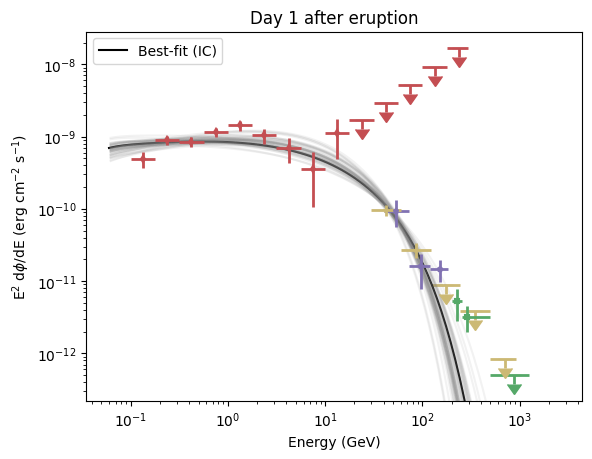

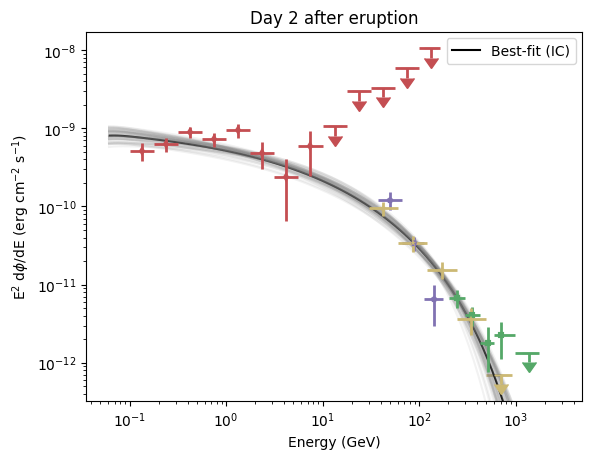

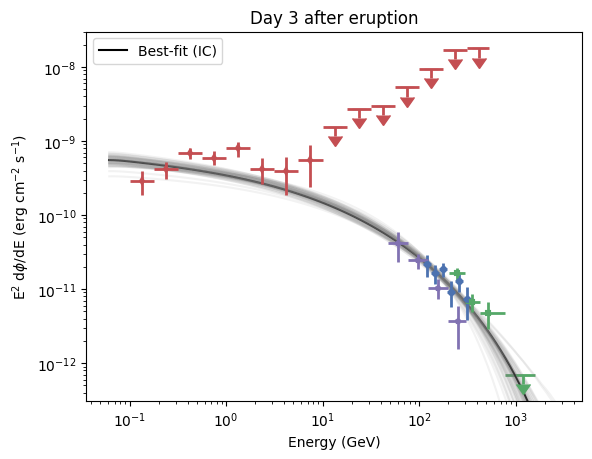

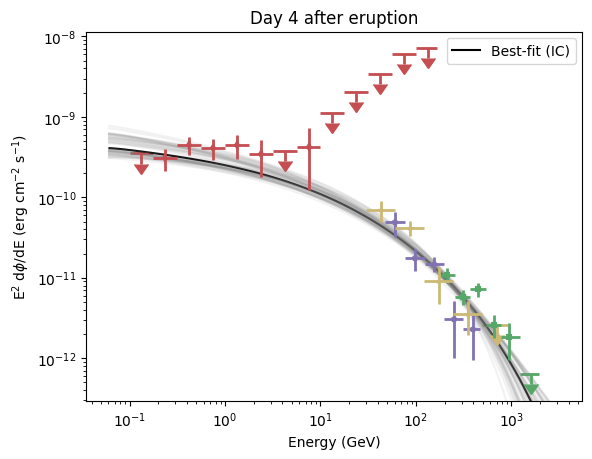

In [21]:
from RSOph_results.leptonic_model.RSOph_leptonic import ICmodel

photon_energy=np.geomspace(0.00006, 2.6,100)*u.TeV

with quantity_support():
    for ii,(day,data,rad_model) in enumerate(
        zip(
            [1,2,3,4],
            daily_data,
            [radiative_model_day1,radiative_model_day2,radiative_model_day3,radiative_model_day4]
        )
    ):

        fig=naima.plot_data(data, e_unit=u.GeV)
        ax = fig.axes[0]
        ax.set_title(f"Day {day} after eruption")

        ax.xaxis.units = u.GeV
        ax.yaxis.units = u.Unit("erg s-1 cm-2")
        ymin, ymax = ax.get_ylim()
        xmin, xmax = ax.get_xlim()
        
        plt.loglog(
            photon_energy,
            rad_model.sed(photon_energy,distance=2.45 * u.kpc),
            color="k",
            label=r"Best-fit (IC)"
        )

        IC_func=ICmodel(day)
        for i in range(min(np.shape(runs_leptonic[ii].get_chain())[1],100)):            
            photon_energy=np.geomspace(xmin,xmax,100)*u.GeV
            flux=IC_func.IC(runs_leptonic[ii].get_chain()[-1,i,:],data=photon_energy)
            # SED := E**2 * differential flux (d\phi/dE)
            plt.loglog(photon_energy,photon_energy**2*flux,color="gray",alpha=0.1)

        ax.set_ylim((ymin, ymax))
        ax.set_ylabel(f"E$^2$ d$\phi$/dE (erg cm$^{{-2}}$ s$^{{-1}}$)")
        ax.set_xlabel(f"Energy (GeV)")    
        ax.legend()